In [61]:
!pip install delta-spark==3.2.0 -q
import pyspark
from delta import *
from pyspark.sql.functions import *

# Create a SparkSession with Delta Lake extensions
# The '.config(...)' lines are crucial for enabling Delta Lake's features
builder = pyspark.sql.SparkSession.builder.appName("DeltaTutorial") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

# Get or create the SparkSession
spark = configure_spark_with_delta_pip(builder).getOrCreate()

print("Spark and Delta Lake are ready!")

Spark and Delta Lake are ready!


In [62]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip
from pyspark.sql import functions as F, types as T
import datetime

trip_schema = T.StructType([
    T.StructField("trip_id", T.IntegerType()),
    T.StructField("rider_id", T.StringType()),
    T.StructField("driver_id", T.StringType()),
    T.StructField("city", T.StringType()),
    T.StructField("distance_km", T.DoubleType()),
    T.StructField("fare", T.DoubleType()),
    T.StructField("tip", T.DoubleType()),
    T.StructField("ts", T.TimestampType())
])

driver_schema = T.StructType([
    T.StructField("driver_id", T.StringType()),
    T.StructField("driver_name", T.StringType()),
    T.StructField("rating", T.DoubleType()),
    T.StructField("vehicle", T.StringType())
])

trips_rows = [
    (1001, "R001", "D010", "Bengaluru", 12.4, 320.0, 20.0, datetime.datetime(2025, 8, 8, 8, 5)),
    (1002, "R002", "D011", "Hyderabad", 6.2, 150.0, 10.0, datetime.datetime(2025, 8, 8, 8, 15)),
    (1003, "R003", "D012", "Pune", 3.5, 90.0, 0.0, datetime.datetime(2025, 8, 8, 8, 20)),
    (1004, "R001", "D010", "Bengaluru", 18.9, 480.0, 25.0, datetime.datetime(2025, 8, 8, 8, 45)),
    (1005, "R004", "D013", "Chennai", 10.0, 260.0, 15.0, datetime.datetime(2025, 8, 8, 9, 5)),
    (1006, "R005", "D012", "Pune", 2.2, 70.0, 0.0, datetime.datetime(2025, 8, 8, 9, 10)),
]

drivers_rows = [
    ("D010", "Anil", 4.8, "WagonR"),
    ("D011", "Sana", 4.6, "i20"),
    ("D012", "Rakesh", 4.4, "Swift"),
    ("D013", "Meera", 4.9, "Ciaz"),
]

trips_df = spark.createDataFrame(trips_rows, schema=trip_schema)
drivers_df = spark.createDataFrame(drivers_rows, schema=driver_schema)

BASE = "/tmp/delta/ride_hailing"
TRIPS_PATH = f"{BASE}/trips"
DRIVERS_PATH = f"{BASE}/drivers"

trips_df.write.format("delta").mode("overwrite").save(TRIPS_PATH)
drivers_df.write.format("delta").mode("overwrite").save(DRIVERS_PATH)

print("Seeded data paths:")
print("Trips ->", TRIPS_PATH)
print("Drivers ->", DRIVERS_PATH)


Seeded data paths:
Trips -> /tmp/delta/ride_hailing/trips
Drivers -> /tmp/delta/ride_hailing/drivers


Managed vs Unmanaged Tables

In [63]:
# managed table
spark.sql(f"""
CREATE TABLE IF NOT EXISTS trips_managed
USING DELTA
AS SELECT * FROM delta.`{TRIPS_PATH}`
""")

# unmanaged table
spark.sql(f"""
CREATE TABLE IF NOT EXISTS drivers_ext
USING DELTA
LOCATION '{DRIVERS_PATH}'
""")

# Verify locations
print("Managed table location:")
spark.sql("DESCRIBE DETAIL trips_managed").show(truncate=False)

print("Unmanaged  table location:")
spark.sql("DESCRIBE DETAIL drivers_ext").show(truncate=False)


Managed table location:
+------+------------------------------------+-----------------------------------+-----------+-------------------------------------------+-----------------------+-----------------------+----------------+-----------------+--------+-----------+----------+----------------+----------------+------------------------+
|format|id                                  |name                               |description|location                                   |createdAt              |lastModified           |partitionColumns|clusteringColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|tableFeatures           |
+------+------------------------------------+-----------------------------------+-----------+-------------------------------------------+-----------------------+-----------------------+----------------+-----------------+--------+-----------+----------+----------------+----------------+------------------------+
|delta |9b05974f-e6d2-4e56-96a3-2aa8192b

Read & Explore

In [64]:
from pyspark.sql.functions import col, expr

# Read both tables
trips_df = spark.sql("SELECT * FROM trips_managed")
drivers_df = spark.sql("SELECT * FROM drivers_ext")

# Print schemas
print("Trips schema:")
trips_df.printSchema()

print("Drivers schema:")
drivers_df.printSchema()

# Show 10 rows from each
print("Trips table sample:")
trips_df.show(10, truncate=False)

print("Drivers table sample:")
drivers_df.show(10, truncate=False)

# Compute derived column: total_amount = fare + tip
trips_with_amt = trips_df.withColumn("total_amount", col("fare") + col("tip"))

# Show top 5 trips by total_amount
print("Top 5 trips by total amount:")
trips_with_amt.orderBy(col("total_amount").desc()).show(5, truncate=False)


Trips schema:
root
 |-- trip_id: integer (nullable = true)
 |-- rider_id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- city: string (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- fare: double (nullable = true)
 |-- tip: double (nullable = true)
 |-- ts: timestamp (nullable = true)

Drivers schema:
root
 |-- driver_id: string (nullable = true)
 |-- driver_name: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- vehicle: string (nullable = true)

Trips table sample:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|city     |distance_km|fare |tip |ts                 |
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|1001   |R001    |D010     |Bengaluru|12.4       |320.0|20.0|2025-08-08 08:05:00|
|1002   |R002    |D011     |Hyderabad|6.2        |150.0|10.0|2025-08-08 08:15:00|
|1003   |R003    |D012     |Pune     |3.5        |90.0 |0.0

Update (Business Rule)

In [65]:
# before update
print("BEFORE UPDATE")
spark.sql("""
select city, tip,distance_km
from trips_managed
where city = 'Bengaluru' """).show()

# update
spark.sql("""
update trips_managed
set tip = tip + 5
where city = 'Bengaluru' and distance_km >15""")

# after update
print("AFTER UPDATE")
spark.sql("""
select city, tip,distance_km
from trips_managed
where city = 'Bengaluru' """).show()

BEFORE UPDATE
+---------+----+-----------+
|     city| tip|distance_km|
+---------+----+-----------+
|Bengaluru|20.0|       12.4|
|Bengaluru|25.0|       18.9|
+---------+----+-----------+

AFTER UPDATE
+---------+----+-----------+
|     city| tip|distance_km|
+---------+----+-----------+
|Bengaluru|20.0|       12.4|
|Bengaluru|30.0|       18.9|
+---------+----+-----------+



Delete (Data Quality)

In [66]:
spark.sql("""
delete from trips_managed
where fare <=0 or distance_km <=0 """)

print("AFTER DELETION")
spark.sql("""
select count(*) as total_rows
from trips_managed""").show()

AFTER DELETION
+----------+
|total_rows|
+----------+
|         6|
+----------+



Merge (Upsert New Batch)

In [67]:

from delta.tables import DeltaTable
new_data = [
    (1004, "R001", "D010", "Bengaluru", 18.9, 500.0, 35.0, datetime.datetime(2025, 8, 8, 8, 45)),
    (1007, "R006", "D011", "Hyderabad", 7.5, 200.0, 12.0, datetime.datetime(2025, 8, 8, 10, 0))
]

new_batch_df = spark.createDataFrame(new_data, schema=trip_schema)

trips_delta = DeltaTable.forName(spark, "trips_managed")

(
    trips_delta.alias("t")
    .merge(
        new_batch_df.alias("n"),
        "t.trip_id = n.trip_id"
    )
    .whenMatchedUpdateAll()
    .whenNotMatchedInsertAll()
    .execute()
)

print("VERIFICATION")
spark.sql("""
    SELECT *
    FROM trips_managed
    WHERE trip_id IN (1004, 1007)
""").show(truncate=False)



VERIFICATION
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|city     |distance_km|fare |tip |ts                 |
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|1004   |R001    |D010     |Bengaluru|18.9       |500.0|35.0|2025-08-08 08:45:00|
|1007   |R006    |D011     |Hyderabad|7.5        |200.0|12.0|2025-08-08 10:00:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



Gold View (Join & KPIs)

In [68]:
# join
gold_df = spark.sql("""
    SELECT
        t.trip_id,
        t.city,
        d.driver_name,
        d.rating,
        t.distance_km,
        (t.fare + t.tip) AS total_amount,
        t.ts
    FROM trips_managed t
    JOIN drivers_ext d
    ON t.driver_id = d.driver_id
""")

# gold view
gold_df.createOrReplaceTempView("gold_view")

spark.sql("""
select * from gold_view""").show()

+-------+---------+-----------+------+-----------+------------+-------------------+
|trip_id|     city|driver_name|rating|distance_km|total_amount|                 ts|
+-------+---------+-----------+------+-----------+------------+-------------------+
|   1004|Bengaluru|       Anil|   4.8|       18.9|       535.0|2025-08-08 08:45:00|
|   1005|  Chennai|      Meera|   4.9|       10.0|       275.0|2025-08-08 09:05:00|
|   1006|     Pune|     Rakesh|   4.4|        2.2|        70.0|2025-08-08 09:10:00|
|   1007|Hyderabad|       Sana|   4.6|        7.5|       212.0|2025-08-08 10:00:00|
|   1001|Bengaluru|       Anil|   4.8|       12.4|       340.0|2025-08-08 08:05:00|
|   1002|Hyderabad|       Sana|   4.6|        6.2|       160.0|2025-08-08 08:15:00|
|   1003|     Pune|     Rakesh|   4.4|        3.5|        90.0|2025-08-08 08:20:00|
+-------+---------+-----------+------+-----------+------------+-------------------+



In [69]:
# city wise revenue and avg driver rating

print("CITY WISE REVENUE AND AVG DRIVER RATING ")
spark.sql("""
    select driver_name,city,sum(total_amount) AS total_revenue,avg(rating) as avg_driver_rating
    from gold_view
    group by city,driver_name
    order by total_revenue desc
""").show()


CITY WISE REVENUE AND AVG DRIVER RATING 
+-----------+---------+-------------+-----------------+
|driver_name|     city|total_revenue|avg_driver_rating|
+-----------+---------+-------------+-----------------+
|       Anil|Bengaluru|        875.0|              4.8|
|       Sana|Hyderabad|        372.0|              4.6|
|      Meera|  Chennai|        275.0|              4.9|
|     Rakesh|     Pune|        160.0|              4.4|
+-----------+---------+-------------+-----------------+



In [70]:
# driver wise total trips

print("DRIVER WISE TOTAL TRIPS")
spark.sql("""
          select driver_name, count(*) as total_trips
          from gold_view
          group by driver_name
          order by total_trips desc""").show()

# top 3

print("TOP 3 DRIVERS BY REVENUE")
spark.sql("""
          select driver_name, sum(total_amount) as total_revenue
          from gold_view
          group by driver_name
          order by total_revenue desc
          limit 3 """).show()

DRIVER WISE TOTAL TRIPS
+-----------+-----------+
|driver_name|total_trips|
+-----------+-----------+
|     Rakesh|          2|
|       Sana|          2|
|       Anil|          2|
|      Meera|          1|
+-----------+-----------+

TOP 3 DRIVERS BY REVENUE
+-----------+-------------+
|driver_name|total_revenue|
+-----------+-------------+
|       Anil|        875.0|
|       Sana|        372.0|
|      Meera|        275.0|
+-----------+-------------+



Time Travel & History

In [71]:
# history
spark.sql(f"describe history delta.`{TRIPS_PATH}`").show(truncate = False)

# version 0
version0 = spark.read.format("delta").option("versionAsOf",0).load(TRIPS_PATH)
version0.show()

# latest
latest =spark.read.format("delta").load(TRIPS_PATH)
latest.show()

print("Counts -> v0:", version0.count(), ", latest:", latest.count())
print("A few rows from version 0:")
version0.orderBy("trip_id").show(5, truncate=False)
print("A few rows from latest:")
latest.orderBy("trip_id").show(5, truncate=False)

+-------+-----------------------+------+--------+--------------+--------------------------------------+----+--------+---------+-----------+--------------+-------------+-----------------------------------------------------------+------------+-----------------------------------+
|version|timestamp              |userId|userName|operation     |operationParameters                   |job |notebook|clusterId|readVersion|isolationLevel|isBlindAppend|operationMetrics                                           |userMetadata|engineInfo                         |
+-------+-----------------------+------+--------+--------------+--------------------------------------+----+--------+---------+-----------+--------------+-------------+-----------------------------------------------------------+------------+-----------------------------------+
|4      |2025-08-14 10:26:38.502|NULL  |NULL    |WRITE         |{mode -> Overwrite, partitionBy -> []}|NULL|NULL    |NULL     |3          |Serializable  |false       

Partitioned Rewrite

In [72]:
PART_TRIPS_PATH = f"{BASE}/trips_by_city"
spark.read.format("delta").load(TRIPS_PATH).write.format("delta").mode("overwrite").partitionBy("city").save(PART_TRIPS_PATH)

print("PARTITIONED PATH: ",PART_TRIPS_PATH)
print("\n LIST OF FILES PRESENT")
import os
for root, dirs, files in os.walk(PART_TRIPS_PATH):
  print(root, "->", files[:5])

print("\nSIMPLE FILTER -- CITY :BANGALURU")
spark.read.format("delta").load(PART_TRIPS_PATH).filter(F.col("city") == "Bengaluru").show(truncate=False)

PARTITIONED PATH:  /tmp/delta/ride_hailing/trips_by_city

 LIST OF FILES PRESENT
/tmp/delta/ride_hailing/trips_by_city -> []
/tmp/delta/ride_hailing/trips_by_city/_delta_log -> ['00000000000000000001.json', '.00000000000000000000.json.crc', '00000000000000000003.json', '.00000000000000000002.json.crc', '.00000000000000000003.json.crc']
/tmp/delta/ride_hailing/trips_by_city/_delta_log/_commits -> []
/tmp/delta/ride_hailing/trips_by_city/city=Chennai -> ['.part-00000-8e34b065-ba61-46e0-b06b-73575791c1ac.c000.snappy.parquet.crc', 'part-00000-68b8d5f6-8a63-4292-9bd6-1376a6a635cc.c000.snappy.parquet', '.part-00000-68b8d5f6-8a63-4292-9bd6-1376a6a635cc.c000.snappy.parquet.crc', 'part-00000-20295c53-770c-454e-badb-c081b1c4e50a.c000.snappy.parquet', 'part-00000-8e34b065-ba61-46e0-b06b-73575791c1ac.c000.snappy.parquet']
/tmp/delta/ride_hailing/trips_by_city/city=Hyderabad -> ['.part-00001-455d7e2d-962a-46aa-9869-017eb35f7e96.c000.snappy.parquet.crc', 'part-00001-9b879529-9467-4f5d-becb-d118a5ca8

Incremental Load Simulation

In [73]:
# new data
inc_rows = [
    (1008, "R007", "D011", "Mumbai", 11.1, 300.0, 20.0, datetime.datetime(2025, 8, 8, 9, 30)),
    (1009, "R008", "D012", "Mumbai", 5.7, 140.0,  8.0, datetime.datetime(2025, 8, 8, 9, 40)),
]

# append
inc_df = spark.createDataFrame(inc_rows,schema=trip_schema)
inc_df.write.format("delta").mode("append").save(TRIPS_PATH)

# re run
current_trips = spark.read.format("delta").load(TRIPS_PATH).withColumn("total_amount", F.col("fare") + F.col("tip"))
city_rev = current_trips.groupBy("city").agg(F.sum("total_amount").alias("total_revenue")).orderBy(F.desc("total_revenue"))
city_rev.show(truncate=False)

+---------+-------------+
|city     |total_revenue|
+---------+-------------+
|Bengaluru|845.0        |
|Mumbai   |468.0        |
|Chennai  |275.0        |
|Pune     |160.0        |
|Hyderabad|160.0        |
+---------+-------------+



In [74]:
current_trips = spark.read.format("delta").load(TRIPS_PATH)
drivers_df = spark.read.format("delta").load(DRIVERS_PATH)

gold_df = (current_trips.alias("t")
           .join(drivers_df.alias("d"), on="driver_id", how="left")
           .withColumn("total_amount", F.col("fare") + F.col("tip"))
           .select("trip_id", "city", "driver_name", "rating", "distance_km", "total_amount", "ts"))

gold_df.createOrReplaceTempView("gold_view")


Simple Streaming

In [75]:
stream_df = (spark.readStream
             .format("delta")
             .load(TRIPS_PATH)
             .withColumn("total_amount", F.col("fare") + F.col("tip")))

query = (stream_df
         .writeStream
         .format("console")
         .outputMode("append")
         .option("truncate", "false")
         .trigger(processingTime="5 seconds")
         .start())

In [76]:
more_mumbai = [
    (1010, "R009", "D010", "Mumbai", 9.0, 220.0, 10.0, datetime.datetime(2025, 8, 8, 10, 0)),
]
spark.createDataFrame(more_mumbai, schema=trip_schema) \
     .write.format("delta").mode("append").save(TRIPS_PATH)

In [77]:
query.stop()

Visualization

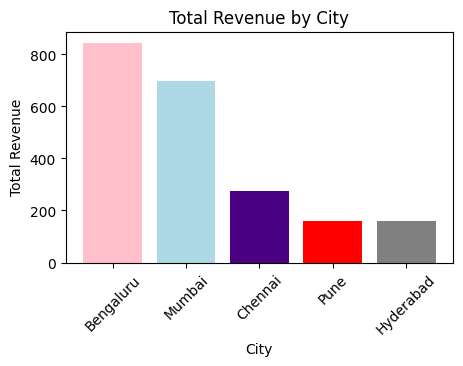

In [78]:
import matplotlib.pyplot as plt

gold_df = spark.table("gold_view")
city_rev_pd = (gold_df.groupBy("city")
               .agg(F.sum("total_amount").alias("total_revenue"))
               .orderBy(F.desc("total_revenue"))
              ).toPandas()

# BAR CHART
plt.figure(figsize=(5,3))
plt.bar(city_rev_pd["city"], city_rev_pd["total_revenue"],color = ['pink','lightblue','indigo','red','grey'])
plt.title("Total Revenue by City")
plt.xlabel("City")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.show()

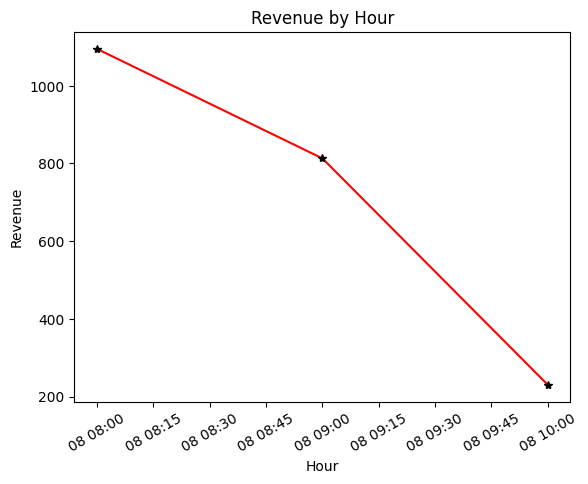

In [79]:
# LINE CHART
hourly = (gold_df
          .withColumn("hour", F.date_trunc("hour", F.col("ts")))
          .groupBy("hour")
          .agg(F.sum("total_amount").alias("hourly_revenue"))
          .orderBy("hour"))
hourly_pd = hourly.toPandas()

plt.figure()
plt.plot(hourly_pd["hour"], hourly_pd["hourly_revenue"],marker = '*',color = 'red',markeredgecolor = 'black',markerfacecolor = 'black')
plt.title("Revenue by Hour")
plt.xlabel("Hour")
plt.ylabel("Revenue")
plt.xticks(rotation=30)
plt.show()

Managed vs Unmanaged Cleanup

In [80]:
spark.sql("DROP TABLE IF EXISTS trips_managed")
spark.sql("DROP TABLE IF EXISTS drivers_ext")

DataFrame[]

In [81]:
# verification
print("Files under DRIVERS_PATH should still exist:")
import os
for root, dirs, files in os.walk(DRIVERS_PATH):
  print(root, "->", files[:5])
  break


Files under DRIVERS_PATH should still exist:
/tmp/delta/ride_hailing/drivers -> ['part-00000-39edef30-a33f-4f70-a83c-242469e6112d-c000.snappy.parquet', '.part-00001-6eb377c7-3ef8-44fb-a632-061cd6f4ab7c-c000.snappy.parquet.crc', '.part-00001-962daac0-2b6b-4ef4-bda5-2bdf3b994c51-c000.snappy.parquet.crc', '.part-00000-39edef30-a33f-4f70-a83c-242469e6112d-c000.snappy.parquet.crc', 'part-00001-962daac0-2b6b-4ef4-bda5-2bdf3b994c51-c000.snappy.parquet']


Constraint/Quality Check

In [82]:
# bad data
bad = [(1011, "R010", "D011", "Pune", 4.0, 100.0, -5.0, datetime.datetime(2025, 8, 8, 10, 10))]
bad_df = spark.createDataFrame(bad, schema=trip_schema)


try:
    bad_df.write.format("delta").mode("append").save(TRIPS_PATH)
    print("Unexpected: bad write succeeded")
except Exception as e:
    print("As expected, bad write blocked by CHECK constraint.")

As expected, bad write blocked by CHECK constraint.


Convert Parquet → Delta

In [83]:
from delta.tables import DeltaTable

PARQ_PATH = f"{BASE}/parquet_subset"
DELTA_FROM_PARQ = f"{BASE}/delta_from_parquet"

subset = spark.read.format("delta").load(TRIPS_PATH).filter(F.col("city") == "Chennai")
subset.write.mode("overwrite").parquet(PARQ_PATH)

DeltaTable.convertToDelta(spark, f"parquet.`{PARQ_PATH}`")

print("CHENNAI ")
spark.read.format("delta").load(PARQ_PATH).show(truncate=False)

target_dt = DeltaTable.forPath(spark, PARQ_PATH)
merge_rows2 = [
    (2001, "R200", "D013", "Chennai", 6.0, 150.0, 10.0, datetime.datetime(2025, 8, 8, 11, 0))
]
merge_df2 = spark.createDataFrame(merge_rows2, schema=trip_schema)

(target_dt.alias("t")
 .merge(merge_df2.alias("s"), "t.trip_id = s.trip_id")
 .whenMatchedUpdateAll()
 .whenNotMatchedInsertAll()
 .execute()
)
print("MERGE")
spark.sql(f"DESCRIBE HISTORY delta.`{PARQ_PATH}`").show(truncate=False)
print("TIME TRAVEL")
spark.read.format("delta").option("versionAsOf", 0).load(PARQ_PATH).show(truncate=False)

CHENNAI 
+-------+--------+---------+-------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|city   |distance_km|fare |tip |ts                 |
+-------+--------+---------+-------+-----------+-----+----+-------------------+
|1005   |R004    |D013     |Chennai|10.0       |260.0|15.0|2025-08-08 09:05:00|
+-------+--------+---------+-------+-----------+-----+----+-------------------+

MERGE
+-------+-----------------------+------+--------+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Bonus KPI Dashboard

TOTAL REVENUE: 2138.0

TRIPS PER CITY



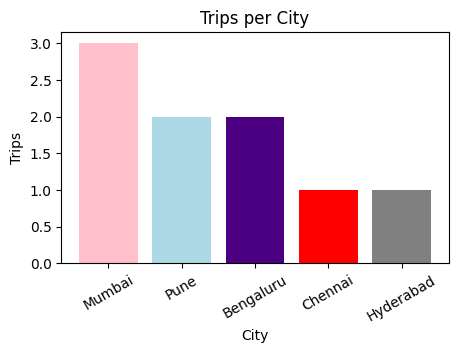


DRIVERS BY REVENUE



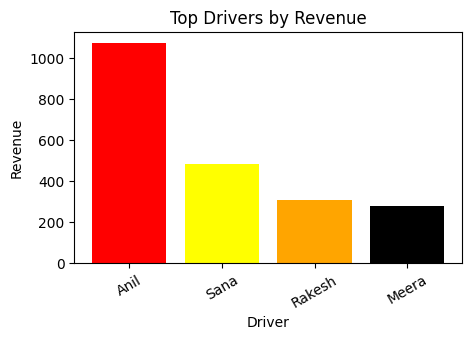


REVENUE BY HOUR



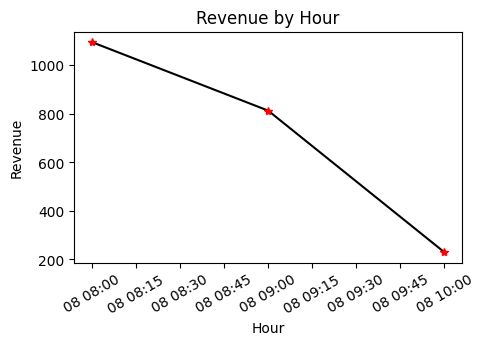

In [85]:
# Total revenue
total_revenue = spark.table("gold_trips").agg(F.sum("total_amount").alias("total_revenue")).collect()[0]["total_revenue"]
print("TOTAL REVENUE:", total_revenue)

# Trips per city
print("\nTRIPS PER CITY\n")
tpc = (spark.table("gold_trips")
       .groupBy("city")
       .agg(F.count("*").alias("trips"))
       .orderBy(F.desc("trips"))).toPandas()

plt.figure(figsize=(5,3))
plt.bar(tpc["city"], tpc["trips"],color = ['pink','lightblue','indigo','red','grey'])
plt.title("Trips per City")
plt.xlabel("City")
plt.ylabel("Trips")
plt.xticks(rotation=30)
plt.show()

# Top drivers by revenue
print("\nDRIVERS BY REVENUE\n")
tdr = (spark.table("gold_trips")
       .groupBy("driver_name")
       .agg(F.sum("total_amount").alias("revenue"))
       .orderBy(F.desc("revenue"))).toPandas()

plt.figure(figsize=(5,3))
plt.bar(tdr["driver_name"], tdr["revenue"],color = ['red','yellow','orange','black'])
plt.title("Top Drivers by Revenue")
plt.xlabel("Driver")
plt.ylabel("Revenue")
plt.xticks(rotation=30)
plt.show()

# Revenue by hour
print("\nREVENUE BY HOUR\n")
rev_hr = (spark.table("gold_trips")
          .withColumn("hour", F.date_trunc("hour", F.col("ts")))
          .groupBy("hour").agg(F.sum("total_amount").alias("revenue"))
          .orderBy("hour")).toPandas()

plt.figure(figsize=(5,3))
plt.plot(rev_hr["hour"], rev_hr["revenue"],marker = '*',markerfacecolor = 'red',markeredgecolor = 'red',color = 'black')
plt.title("Revenue by Hour")
plt.xlabel("Hour")
plt.ylabel("Revenue")
plt.xticks(rotation=30)
plt.show()
